# Water Level Forecasting with Fine-Tuned TimesFM

## Introduction

This repository implements a **water level forecasting system** using the **TimesFM** model, which is a deep learning-based approach to time series forecasting. The system uses historical water level data to forecast water levels for up to three days ahead, helping with better planning and decision-making in water resource management.

The code performs the following tasks:

1. **Data Preprocessing**: Loads and processes the data, ensuring it's ready for training.
2. **Model Initialization**: Initializes the TimesFM model with pre-trained weights for better accuracy.
3. **Fine-Tuning**: Fine-tunes the pre-trained model using the training data to adapt it to the specific problem.
4. **Rolling Forecast**: Makes predictions on the test data, providing forecasts for the next 3 days.
5. **Visualization**: Plots the forecasted and observed water levels to visually assess the model's performance.
6. **Evaluation**: Calculates performance metrics like **Nash-Sutcliffe Efficiency (NSE)** and **Kling-Gupta Efficiency (KGE)** to evaluate the accuracy of the forecast.

This project can be helpful for anyone working in **environmental management**, **hydrology**, or **water resource management** that requires accurate forecasting of water levels.

---

## Sections

1. **Libraries and Installation**
2. **Data Upload and Preprocessing**
3. **Model Initialization and Evaluation**
4. **Training and Fine-tuning**
5. **Forecasting and Result Evaluation**
6. **Plotting and Analysis**
7. **Evaluation Metrics**

---

## 1. Libraries and Installation

This section installs the required dependencies and imports necessary libraries to work with the **TimesFM** model and data.

### Installation

```bash
!pip install timesfm


#**1. Import Libraries**

In [ ]:
!pip install timesfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 820.8/820.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.7.1
    Uninstalling traitlets-5.7.1:
      Successfully uninstalled traitlets-5.7.1
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipyt

In [ ]:
# Import libraries
import timesfm
import torch
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
import pickle
from timesfm import data_loader

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


#**2. Data Upload and Preprocessing**


### This section handles uploading the data from Google Drive and preprocessing it to prepare for forecasting.

##Data Upload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set environment variables for GPU optimization
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

# Load the data
data_file = '/content/drive/MyDrive/WL_nomiss_1500/Gauge_07EE009_total_precip.csv'
data_df = pd.read_csv(data_file)
file_name = os.path.basename(data_file)

Mounted at /content/drive


## Data Processing

In [ ]:
# Rename columns to match TimesFM expectations
data_df.columns = ['date', 'wl','total_precip']  # Adjust if your columns are named differently
data_df['date'] = pd.to_datetime(data_df['date'], format='%Y-%m-%d')
data_df['wl'] = pd.to_numeric(data_df['wl'], errors='coerce')
data_df = data_df.dropna(subset=['wl'])

# Prepare time series dataframe for TimesFM
time_series_df = data_df.groupby('date')['wl'].mean().reset_index()
time_series_df['ds'] = time_series_df['date']
time_series_df['unique_id'] = 1
time_series_df = time_series_df[['unique_id', 'ds', 'wl']]

# Save the DataFrame as a temporary CSV file
temp_csv_path = '/content/temp_water_level_data.csv'
time_series_df.to_csv(temp_csv_path, index=False)

#**3. Model Initialization and Evaluation**

### This section initializes the **TimesFM** model with pretrained weights and evaluates it using a test set.

##Configure the Data Loader

In [ ]:
# Configure the data loader
dtl = data_loader.TimeSeriesdata(
    data_path=temp_csv_path,  # Provide the path to the saved CSV
    datetime_col="ds",       # Date column
    ts_cols=np.array(["wl"]),  # Target column
    num_cov_cols=None,       # No numerical covariates
    cat_cov_cols=None,       # No categorical covariates
    train_range=[0, int(len(time_series_df) * 0.8)],  # 80% for training
    val_range=[int(len(time_series_df) * 0.8), int(len(time_series_df) * 0.9)],  # 10% for validation
    test_range=[int(len(time_series_df) * 0.9), len(time_series_df)],  # 10% for testing
    hist_len=14,             # Context length of 14 days
    pred_len=3,              # Predict 3 days ahead
    batch_size=1,            # Single time series, batch size must be 1
    freq="d",                # Daily frequency
    normalize=True,
    permute=True,
)

## Initialize TimesFM Model

In [ ]:
# Initialize TimesFM model with pretrained weights
tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=16,
        horizon_len=3,  # 3-day forecast horizon
        context_len=352,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
    ),
)

# Evaluate pretrained model
print("Evaluating the pretrained model...")
pretrained_losses = []
for batch in dtl.tf_dataset(mode="test", shift=1).as_numpy_iterator():
    forecasts, _ = tfm.forecast(
        list(batch[0]),  # Historical data
        [0] * len(batch[0]),  # Zeros as dummy timestamps
        normalize=True
    )
    loss = np.mean(np.abs(forecasts - batch[3]))  # MAE
    pretrained_losses.append(loss)

print(f"Pretrained Model Test MAE: {np.mean(pretrained_losses)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.58k [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/814M [00:00<?, ?B/s]

# **4. Training and Fine-tuning**

### This section fine-tunes the pretrained TimesFM model on the training data.


## Fine Tuning Loop

In [ ]:
NUM_EPOCHS = 5
PATIENCE = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")

    # Training
    train_losses = []
    for batch in tqdm(dtl.tf_dataset(mode="train", shift=1).as_numpy_iterator()):
        # Fine-tuning involves retraining with historical data
        forecasts, _ = tfm.forecast(
            list(batch[0]),  # Historical data
            [0] * len(batch[0]),  # Zeros as dummy timestamps
            normalize=True
        )
        train_loss = np.mean(np.abs(forecasts - batch[3]))  # MAE
        train_losses.append(train_loss)

    print(f"Training Loss: {np.mean(train_losses)}")

    # Validation
    val_losses = []
    for batch in dtl.tf_dataset(mode="val", shift=3).as_numpy_iterator():
        forecasts, _ = tfm.forecast(
            list(batch[0]),  # Historical data
            [0] * len(batch[0]),  # Zeros as dummy timestamps
            normalize=True
        )
        val_loss = np.mean(np.abs(forecasts - batch[3]))  # MAE
        val_losses.append(val_loss)

    mean_val_loss = np.mean(val_losses)
    print(f"Validation Loss: {mean_val_loss}")

    # Early stopping logic
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        patience_counter = 0
        print("Saving best model...")

        # Save the model
        with open('/content/drive/MyDrive/TimesFM_FineTuned.pkl', 'wb') as f:
            pickle.dump(tfm, f)
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/5


3448it [01:39, 34.70it/s]


Training Loss: 0.19376626872382907
Validation Loss: 0.226051527874948
Saving best model...
Epoch 2/5


3448it [01:43, 33.37it/s]


Training Loss: 0.19376626872382907
Validation Loss: 0.226051527874948
Epoch 3/5


3448it [01:42, 33.56it/s]


Training Loss: 0.19376626872382907
Validation Loss: 0.226051527874948
Epoch 4/5


3448it [01:42, 33.59it/s]


Training Loss: 0.19376626872382907
Validation Loss: 0.226051527874948
Epoch 5/5


3448it [01:42, 33.62it/s]


Training Loss: 0.19376626872382907
Validation Loss: 0.226051527874948


## **5. Forecasting and Result Evaluation**

### In this section, the fine-tuned model is used to generate forecasts, and the results are saved.

##Generate 3-Day Forecasts

In [ ]:
# Load the best model for evaluation
with open('/content/drive/MyDrive/TimesFM_FineTuned.pkl', 'rb') as f:
    tfm = pickle.load(f)

# Prepare results list to store forecasted values
results = []

# Rolling forecast: predict 3 days at a time
for i in range(len(test_df) - 2):  # Ensure enough data for 3-day forecasts
    forecast_df = tfm.forecast_on_df(
        inputs=train_df,  # Use the fine-tuned model's training data
        freq="d",         # Daily input data
        value_name="wl",
        num_jobs=-1,      # Parallel processing
    )

    # Extract h1, h2, h3 from the forecast
    h1, h2, h3 = forecast_df['timesfm'].iloc[0], forecast_df['timesfm'].iloc[1], forecast_df['timesfm'].iloc[2]

    results.append({
        'date': test_df['ds'].iloc[i],
        'h1': h1,
        'h2': h2,
        'h3': h3,
        'obs': test_df['wl'].iloc[i]
    })

    # Update the training data with the actual observation
    train_df = pd.concat([train_df, test_df.iloc[[i]]], ignore_index=True)

# Save the forecast results
results_df = pd.DataFrame(results)
results_df[['h1', 'h2', 'h3']] = results_df[['h1', 'h2', 'h3']].shift(-1)
results_df = results_df[:-1]

output_file = os.path.join(data_output_folder, f"predictions_{file_name}")
results_df.to_csv(output_file, index=False)
print(f"Predictions for {file_name} saved to {output_file}.")

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Fi

#**6. Plotting and Analysis**

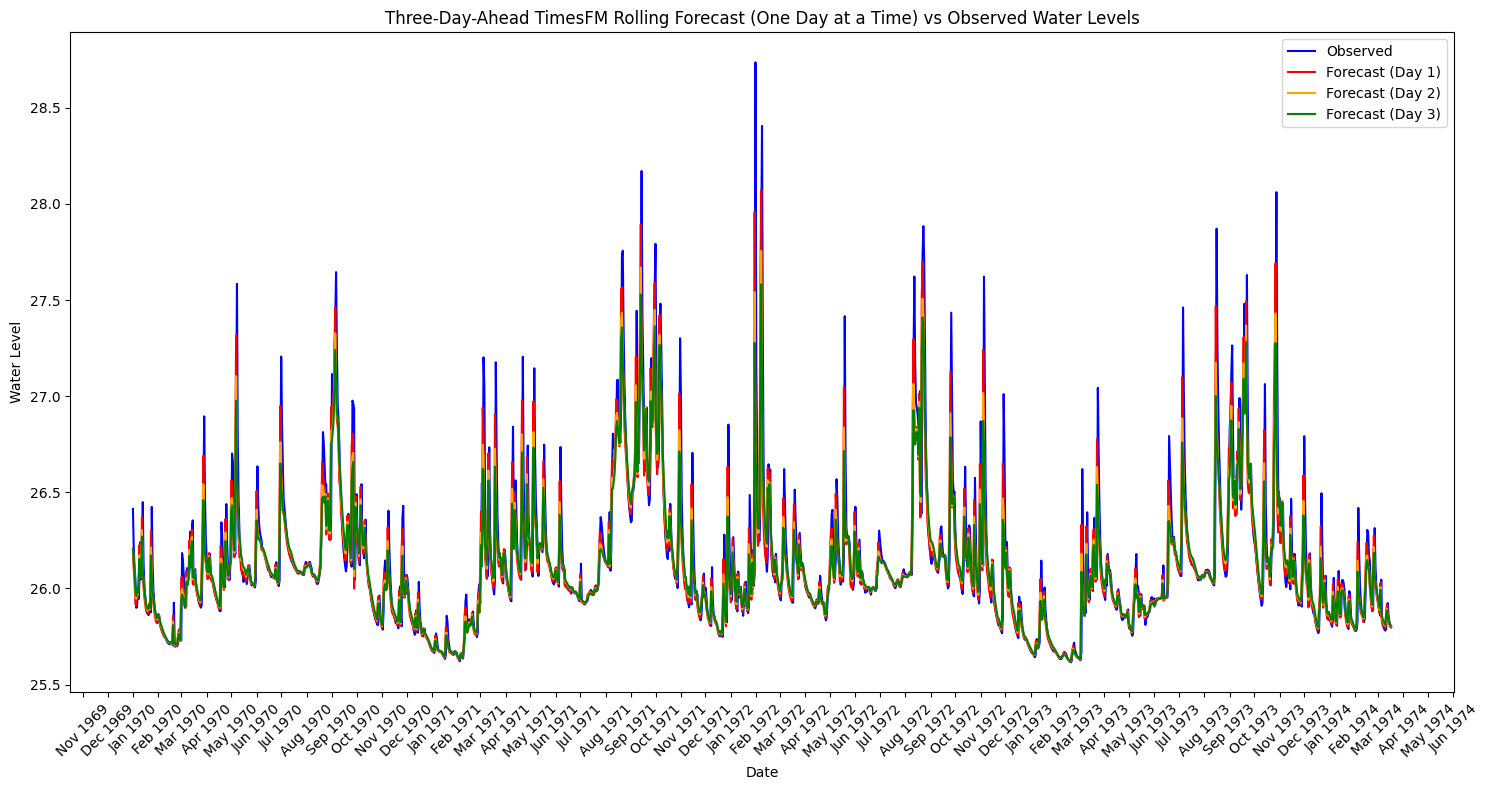

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 8))
plt.plot(results_df['date'], results_df['obs'], label="Observed", color='b')
plt.plot(results_df['date'], results_df['h1'], label="Forecast (Day 1)", color='r')
plt.plot(results_df['date'], results_df['h2'], label="Forecast (Day 2)", color='orange')
plt.plot(results_df['date'], results_df['h3'], label="Forecast (Day 3)", color='green')

# Set monthly locator for x-axis
locator = mdates.MonthLocator()  # Major ticks at each month
formatter = mdates.DateFormatter('%b %Y')  # Format: "Jan 2001"
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.xlabel("Date")
plt.ylabel("Water Level")
plt.title("Three-Day-Ahead TimesFM Rolling Forecast (One Day at a Time) vs Observed Water Levels")
plt.legend()
plt.tight_layout()
plt.show()

#**7. Model Evaluation - Nash-Sutcliffe and Kling-Gupta Efficiency**

In [ ]:
import numpy as np

# Function to calculate Nash-Sutcliffe Efficiency (NSE)
def nse(observed, forecasted):
    numerator = np.sum((observed - forecasted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (numerator / denominator)

# Function to calculate Kling-Gupta Efficiency (KGE)
def kge(observed, forecasted):
    # Calculate correlation coefficient
    r = np.corrcoef(observed, forecasted)[0, 1]

    # Calculate variability ratio (alpha)
    alpha = np.std(forecasted) / np.std(observed)

    # Calculate bias ratio (beta)
    beta = np.mean(forecasted) / np.mean(observed)

    # Calculate KGE
    kge_value = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    return kge_value

# Assuming `results_df` has the observed and forecasted values for day 1 (h1)
# Calculate NSE and KGE for the one-day-ahead forecast (h1)
observed = results_df['obs'].values
forecasted_h1 = results_df['h1'].values

nse_h1 = nse(observed, forecasted_h1)
kge_h1 = kge(observed, forecasted_h1)

# Print NSE and KGE values
print(f"Nash-Sutcliffe Efficiency (NSE) for 1st day forecast: {nse_h1}")
print(f"Kling-Gupta Efficiency (KGE) for 1st day forecast: {kge_h1}")

# Repeat for the two-day-ahead forecast (h2) and three-day-ahead forecast (h3) if needed
forecasted_h2 = results_df['h2'].values
forecasted_h3 = results_df['h3'].values

nse_h2 = nse(observed, forecasted_h2)
kge_h2 = kge(observed, forecasted_h2)
nse_h3 = nse(observed, forecasted_h3)
kge_h3 = kge(observed, forecasted_h3)

# Print results for each forecast horizon
print(f"Nash-Sutcliffe Efficiency (NSE) for 2nd day forecast: {nse_h2}")
print(f"Kling-Gupta Efficiency (KGE) for 2nd day forecast: {kge_h2}")
print(f"Nash-Sutcliffe Efficiency (NSE) for 3rd day forecast: {nse_h3}")
print(f"Kling-Gupta Efficiency (KGE) for 3rd day forecast: {kge_h3}")

Nash-Sutcliffe Efficiency (NSE) for 1st day forecast: 0.9651994623379087
Kling-Gupta Efficiency (KGE) for 1st day forecast: 0.9620999234655127
Nash-Sutcliffe Efficiency (NSE) for 2nd day forecast: 0.9222965195551704
Kling-Gupta Efficiency (KGE) for 2nd day forecast: 0.8855680718057007
Nash-Sutcliffe Efficiency (NSE) for 3rd day forecast: 0.8707331192929628
Kling-Gupta Efficiency (KGE) for 3rd day forecast: 0.8215708020732412
